# 

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import data, exposure

import os


In [2]:
test_dir = '/kaggle/input/raf-db-dataset/DATASET/test'
train_dir = '/kaggle/input/raf-db-dataset/DATASET/train'

In [3]:
!ls /kaggle/input/raf-db-dataset/DATASET/test/1/test_0789_aligned.jpg

/kaggle/input/raf-db-dataset/DATASET/test/1/test_0789_aligned.jpg


# SIFT -
# FAST -
# HOG +
# LBP -
# canny +
# Haar - not have good filters

In [4]:
girl = resize(imread('/kaggle/input/raf-db-dataset/DATASET/test/1/test_0002_aligned.jpg'),(32,32))
girl.shape

(32, 32, 3)

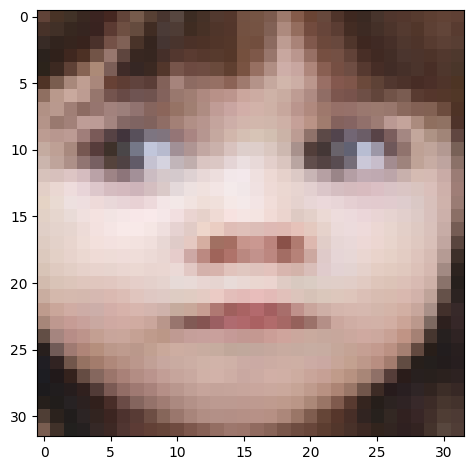

In [5]:
imshow(girl)

In [6]:
from skimage.feature import canny
from skimage.color import rgb2gray
gray = rgb2gray(girl)
canny_girl1 = canny(gray)
canny_girl2 = canny(gray, sigma=2)

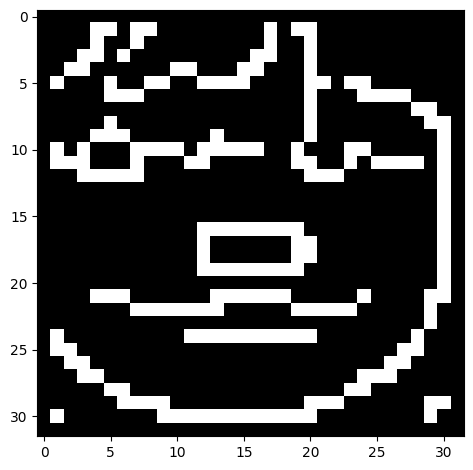

In [7]:
imshow(canny_girl1)

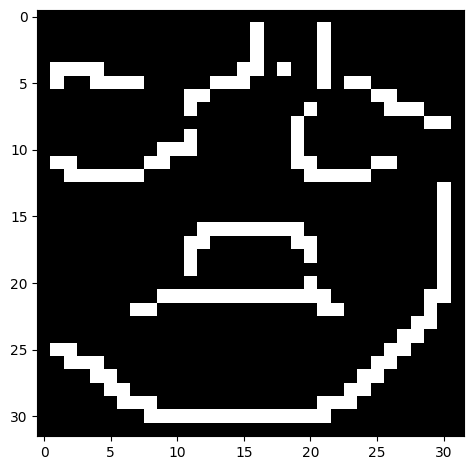

In [8]:
imshow(canny_girl2)

In [9]:
def dataset_by_path(path, convector):
    X = []
    y = []
    i=0

    for class_name in os.listdir(path):
        path_to =path+'/'+class_name
        for img_path in os.listdir(path_to):
            y.append(int(class_name))
            img_arr = convector(imread(path_to+'/'+img_path))
            X.append(img_arr)
    return np.array(X),np.array(y)



In [10]:
hog_conv = lambda x: resize(rgb2gray(x),(32,32)).flatten()

In [11]:
test_f_hog ,test_label =dataset_by_path(test_dir,hog_conv)
train_f_hog ,train_label =dataset_by_path(train_dir,hog_conv)


# method
# pca 
# model 
# catboost
# svm
# random forest

In [12]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

SEED=42

In [13]:
import optuna

def data_objectivePCA_RF(trial):
    x, xt, y, yt = train_f_hog,test_f_hog,train_label,test_label

    params = {
        "criterion":trial.suggest_categorical("criterion",['gini', 'entropy','log_loss']),
        "n_estimators": trial.suggest_int('n_estimators', 100, 1000, log=True),
        "max_features": trial.suggest_categorical("max_features", ['log2', 'sqrt',None]) ,
        "max_depth": trial.suggest_int("max_depth", 10, 110),
        "min_samples_split": trial.suggest_int("min_samples_split", 2,50),
        "min_samples_leaf": trial.suggest_float("min_samples_leaf", 0.1,0.9)
    }
    pca_param ={
        "n_components": trial.suggest_float("n_components", 0.4, 0.9999),
        'power_iteration_normalizer': trial.suggest_categorical('power_iteration_normalizer',
            ['auto', 'QR', 'LU', 'none']
        ),
        'svd_solver':'full',

    }
    pca = PCA(**pca_param).fit(x,y)
    x = pca.transform(x)
    xt = pca.transform(xt)
            
    clf = RandomForestClassifier(random_state=SEED, **params)
    clf.fit(x, y)
    y_pred = clf.predict(xt)
    acc = accuracy_score(yt, y_pred)
    print(params,pca_param,acc,sep='\n')
    return acc

def data_objective_RF(trial):
    x, xt, y, yt = train_f_hog,test_f_hog,train_label,test_label
    params = {
        "criterion":trial.suggest_categorical("criterion",['gini', 'entropy','log_loss']),
        "n_estimators": trial.suggest_int('n_estimators', 100, 1000, log=True),
        "max_features": trial.suggest_categorical("max_features", ['log2', 'sqrt',None]) ,
        "max_depth": trial.suggest_int("max_depth", 10, 110),
        "min_samples_split": trial.suggest_int("min_samples_split", 2,50),
        "min_samples_leaf": trial.suggest_float("min_samples_leaf", 0.1,0.9)
    }
    clf = RandomForestClassifier(random_state=SEED, **params)
    clf.fit(x, y)
    y_pred = clf.predict(xt)
    acc = accuracy_score(yt, y_pred)
    print(params,acc,sep='\n')
    return acc


In [14]:
study = optuna.create_study(direction="maximize")
study.optimize(data_objectivePCA_RF, n_trials=100, timeout=600, n_jobs=2)
print("Number of finished trials: {}".format(len(study.trials)))
trial = study.best_trial
print("  Value: {}".format(trial.value))
print(trial.params)


{'criterion': 'entropy', 'n_estimators': 107, 'max_features': None, 'max_depth': 19, 'min_samples_split': 17, 'min_samples_leaf': 0.7189781433544307}
{'n_components': 0.7959609348551013, 'power_iteration_normalizer': 'QR', 'svd_solver': 'full'}
0.386245110821382
{'criterion': 'log_loss', 'n_estimators': 239, 'max_features': None, 'max_depth': 16, 'min_samples_split': 16, 'min_samples_leaf': 0.8988066834209207}
{'n_components': 0.4483073881989778, 'power_iteration_normalizer': 'QR', 'svd_solver': 'full'}
0.386245110821382
{'criterion': 'log_loss', 'n_estimators': 149, 'max_features': 'sqrt', 'max_depth': 104, 'min_samples_split': 37, 'min_samples_leaf': 0.5762824038204376}
{'n_components': 0.6497526103076254, 'power_iteration_normalizer': 'none', 'svd_solver': 'full'}
0.386245110821382
{'criterion': 'entropy', 'n_estimators': 122, 'max_features': 'log2', 'max_depth': 36, 'min_samples_split': 29, 'min_samples_leaf': 0.21482902904278403}
{'n_components': 0.553012943496546, 'power_iteratio

In [15]:

study = optuna.create_study(direction="maximize")
study.optimize(data_objective_RF, n_trials=100, timeout=600, n_jobs=2)
print("Number of finished trials: {}".format(len(study.trials)))
trial = study.best_trial
print("  Value: {}".format(trial.value))
print(trial.params)

{'criterion': 'gini', 'n_estimators': 728, 'max_features': None, 'max_depth': 72, 'min_samples_split': 14, 'min_samples_leaf': 0.7728675035285314}
0.386245110821382
{'criterion': 'entropy', 'n_estimators': 464, 'max_features': 'sqrt', 'max_depth': 91, 'min_samples_split': 21, 'min_samples_leaf': 0.2644877023306097}
0.386245110821382
{'criterion': 'log_loss', 'n_estimators': 270, 'max_features': 'sqrt', 'max_depth': 35, 'min_samples_split': 14, 'min_samples_leaf': 0.7864849312223118}
0.386245110821382
{'criterion': 'log_loss', 'n_estimators': 840, 'max_features': 'sqrt', 'max_depth': 101, 'min_samples_split': 34, 'min_samples_leaf': 0.38383729405354794}
0.386245110821382
{'criterion': 'entropy', 'n_estimators': 412, 'max_features': 'sqrt', 'max_depth': 74, 'min_samples_split': 38, 'min_samples_leaf': 0.6213552301031223}
0.386245110821382
{'criterion': 'log_loss', 'n_estimators': 646, 'max_features': None, 'max_depth': 85, 'min_samples_split': 36, 'min_samples_leaf': 0.5774099595342553}


In [16]:
def data_objectivePCA_SVC(trial):
    x, xt, y, yt = train_f_hog,test_f_hog,train_label,test_label

    params = {
        "C": trial.suggest_float('C', 0.5, 5),
        "decision_function_shape": trial.suggest_categorical("decision_function_shape", ['ovo', 'ovr']) ,
        "kernel": trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']),
    }
    if params['kernel'] =='poly':
        params['degree'] = trial.suggest_int('degree',2,10)
        
    pca_param ={
        "n_components": trial.suggest_float("n_components", 0.4, 0.9999),
        'power_iteration_normalizer': trial.suggest_categorical('power_iteration_normalizer',
            ['auto', 'QR', 'LU', 'none']
        ),
        'svd_solver':'full',

    }
    pca = PCA(**pca_param).fit(x,y)
    x = pca.transform(x)
    xt = pca.transform(xt)
            
    clf = SVC(random_state=SEED, **params)
    clf.fit(x, y)
    y_pred = clf.predict(xt)
    acc = accuracy_score(yt, y_pred)
    print(params,pca_param,acc,sep='\n')
    return acc

def data_objective_SVC(trial):
    x, xt, y, yt = train_f_hog,test_f_hog,train_label,test_label

    params = {
        "C": trial.suggest_float('C', 0.5, 5),
        "decision_function_shape": trial.suggest_categorical("decision_function_shape", ['ovo', 'ovr']) ,
        "kernel": trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid', ]),
    }
    if params['kernel'] =='poly':
        params['degree'] = trial.suggest_int('degree',2,10)
        
   
            
    clf = SVC(random_state=SEED, **params)
    clf.fit(x, y)
    y_pred = clf.predict(xt)
    acc = accuracy_score(yt, y_pred)
    print(params,acc,sep='\n')
    return acc

In [17]:
study = optuna.create_study(direction="maximize")
study.optimize(data_objectivePCA_SVC, n_trials=100, timeout=2200, n_jobs=2)
print("Number of finished trials: {}".format(len(study.trials)))
trial = study.best_trial
print("  Value: {}".format(trial.value))
print(trial.params)



{'C': 1.4915698460081814, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
{'n_components': 0.424543728063158, 'power_iteration_normalizer': 'LU', 'svd_solver': 'full'}
0.386245110821382
{'C': 1.0735319372256313, 'decision_function_shape': 'ovr', 'kernel': 'poly', 'degree': 4}
{'n_components': 0.9385380730067618, 'power_iteration_normalizer': 'auto', 'svd_solver': 'full'}
0.46740547588005216
{'C': 3.705806699102618, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
{'n_components': 0.6060814335300602, 'power_iteration_normalizer': 'QR', 'svd_solver': 'full'}
0.3425684485006519
{'C': 2.6866680071422557, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
{'n_components': 0.9056740974073806, 'power_iteration_normalizer': 'auto', 'svd_solver': 'full'}
0.5915906127770535
{'C': 3.1066135043413223, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
{'n_components': 0.5953327101031627, 'power_iteration_normalizer': 'auto', 'svd_solver': 'full'}
0.3428943937418514
{'C': 4.98966

In [18]:
study = optuna.create_study(direction="maximize")
study.optimize(data_objective_SVC, n_trials=100, timeout=2200, n_jobs=2)
print("Number of finished trials: {}".format(len(study.trials)))
trial = study.best_trial
print("  Value: {}".format(trial.value))
print(trial.params)

{'C': 3.886354223314319, 'decision_function_shape': 'ovr', 'kernel': 'rbf'}
0.6802477183833116
{'C': 2.404602796625988, 'decision_function_shape': 'ovr', 'kernel': 'rbf'}
0.6760104302477183
{'C': 3.6825087997236046, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
0.27835723598435463
{'C': 3.5066743314928317, 'decision_function_shape': 'ovr', 'kernel': 'sigmoid'}
0.2796610169491525
{'C': 4.156650510096789, 'decision_function_shape': 'ovr', 'kernel': 'sigmoid'}
0.27640156453715775
{'C': 3.757932120904888, 'decision_function_shape': 'ovo', 'kernel': 'linear'}
0.6316818774445893
{'C': 2.650454846645246, 'decision_function_shape': 'ovr', 'kernel': 'rbf'}
0.6740547588005215
{'C': 2.71027413654587, 'decision_function_shape': 'ovr', 'kernel': 'rbf'}
0.6760104302477183
{'C': 1.9368962204963773, 'decision_function_shape': 'ovr', 'kernel': 'poly', 'degree': 9}
0.5179269882659713
{'C': 4.71039626465818, 'decision_function_shape': 'ovr', 'kernel': 'sigmoid'}
0.2728161668839635
{'C': 2.446859

In [19]:


def objectivePCA_CAT(trial):
    x, xt, y, yt = train_f_hog,test_f_hog,train_label,test_label
    param = {
        "objective": trial.suggest_categorical("objective", ["MultiClass", "MultiClassOneVsAll"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli"]
        ),
        "used_ram_limit": "25gb",
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
        'n_estimators': trial.suggest_int('n_estimators', 4, 200),
        'max_bin': trial.suggest_int('max_bin', 100, 400),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log=True),
        'random_seed': 42,
        'task_type': 'CPU',
        'eval_metric': 'Accuracy',
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    pca_param ={
        "n_components": trial.suggest_float("n_components", 0.2, 0.9999),
        'power_iteration_normalizer': trial.suggest_categorical('power_iteration_normalizer',
            ['auto', 'QR', 'LU', 'none']
        ),
        'svd_solver':'full',

    }
    
    pca = PCA(**pca_param).fit(x,y)
    x = pca.transform(x)
    xt = pca.transform(xt)
    gbm = CatBoostClassifier(**param)

    gbm.fit(x, y, eval_set=[(xt, yt)], verbose=0, early_stopping_rounds=10)
    preds = gbm.predict(xt)
    pred_labels = np.rint(preds)

    acc = gbm.get_best_score()['validation']['Accuracy']
    print(param,pca_param,acc,sep='\n')
    return acc
def objective_CAT(trial):
    x, xt, y, yt = train_f_hog,test_f_hog,train_label,test_label
    param = {
        "objective": trial.suggest_categorical("objective", ["MultiClass", "MultiClassOneVsAll"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli"]
        ),
        "used_ram_limit": "25gb",
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
        'n_estimators': trial.suggest_int('n_estimators', 4, 200),
        'max_bin': trial.suggest_int('max_bin', 100, 400),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log=True),
        'random_seed': 42,
        'task_type': 'CPU',
        'eval_metric': 'Accuracy',
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
   
    gbm = CatBoostClassifier(**param)

    gbm.fit(x, y, eval_set=[(xt, yt)], verbose=0, early_stopping_rounds=10)
    preds = gbm.predict(xt)
    pred_labels = np.rint(preds)

    acc = gbm.get_best_score()['validation']['Accuracy']
    print(param,acc,sep='\n')
    return acc

In [20]:
study = optuna.create_study(direction="maximize")
study.optimize(objectivePCA_CAT, n_trials=100, timeout=1200, n_jobs=2)
print("Number of finished trials: {}".format(len(study.trials)))
trial = study.best_trial
print("  Value: {}".format(trial.value))
print(trial.params)

{'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.012728059084220294, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'used_ram_limit': '25gb', 'max_depth': 7, 'learning_rate': 0.08, 'n_estimators': 184, 'max_bin': 137, 'min_data_in_leaf': 29, 'l2_leaf_reg': 0.0024569348064890357, 'random_seed': 42, 'task_type': 'CPU', 'eval_metric': 'Accuracy', 'subsample': 0.6835163371013364}
{'n_components': 0.5758592593892223, 'power_iteration_normalizer': 'none', 'svd_solver': 'full'}
0.386245110821382
{'objective': 'MultiClass', 'colsample_bylevel': 0.028170179285289455, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'used_ram_limit': '25gb', 'max_depth': 5, 'learning_rate': 0.02, 'n_estimators': 37, 'max_bin': 363, 'min_data_in_leaf': 136, 'l2_leaf_reg': 0.031175172183775954, 'random_seed': 42, 'task_type': 'CPU', 'eval_metric': 'Accuracy', 'bagging_temperature': 7.62390683592049}
{'n_components': 0.6434209359174005, 'power_iteration_normalizer': 'none', 'svd_solver': 

In [21]:


study = optuna.create_study(direction="maximize")
study.optimize(objective_CAT, n_trials=100, timeout=1200, n_jobs=2)
print("Number of finished trials: {}".format(len(study.trials)))
trial = study.best_trial
print("  Value: {}".format(trial.value))
print(trial.params)

{'objective': 'MultiClass', 'colsample_bylevel': 0.08100319776688755, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'used_ram_limit': '25gb', 'max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 7, 'max_bin': 199, 'min_data_in_leaf': 260, 'l2_leaf_reg': 0.4651595456380178, 'random_seed': 42, 'task_type': 'CPU', 'eval_metric': 'Accuracy', 'subsample': 0.8059045538923194}
0.47359843546284225
{'objective': 'MultiClass', 'colsample_bylevel': 0.013266165004286679, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'used_ram_limit': '25gb', 'max_depth': 8, 'learning_rate': 0.05, 'n_estimators': 183, 'max_bin': 314, 'min_data_in_leaf': 85, 'l2_leaf_reg': 0.0028572358327633566, 'random_seed': 42, 'task_type': 'CPU', 'eval_metric': 'Accuracy', 'bagging_temperature': 7.409026273234206}
0.49674054758800523
{'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.04672499544441932, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'used_ram_limit': '25gb', 'max_depth': 7